## Path sampling

This notebook contains the code for Qijia's path sampling idea.

First, imports:

In [1]:
import jax
import jax.numpy as jnp
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
import os
from functools import partial
from path_sampling import dfdt, div_f, update, update_non_amortized


`batch_size` is the number of paths (that we use each time we update the drift)

`ndims` is the number of dimensions of the problem. Here we work with a TPS example, of a double well in 2D.

In [2]:
# this allows for parallelization with pmap. Not currently used
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(200)

# currently we're just doing an SDE on \mathbb{R}
ndims = 1


We now define a function that generates random paths given a drift term `b` and a noise term `W`:

## Example of a path in a double well

Here's an example of sampling a path in a double well potential.

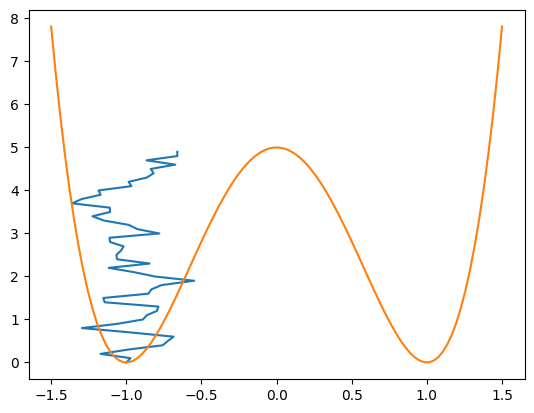

In [3]:
from path_sampling import make_double_well_potential, sample_sde


hyperparams={'dt': 0.01, 'num_steps': 50, 'num_training_steps' : 1000}


potential = make_double_well_potential(v=5.0)

def uref(x, t): 
    # potential = lambda x: jnp.sum(x**4 - 8 * x**2,axis=-1)
    return -jax.grad(potential)(x)

path, time = sample_sde(
    b=uref, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=jax.random.key(0), 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps'])

# visualize path
plt.plot(path,time*10)
# plot potential
x = np.linspace(-1.5, 1.5, 100)

plt.plot(x, potential(x[:, None]))

old s 0.0
Train loss: 426483.65625
Test loss is 484870.375
old s 0.1
Train loss: 105848.4453125
Test loss is 123657.2265625
old s 0.5
Train loss: 11086.189453125
Test loss is 10827.265625


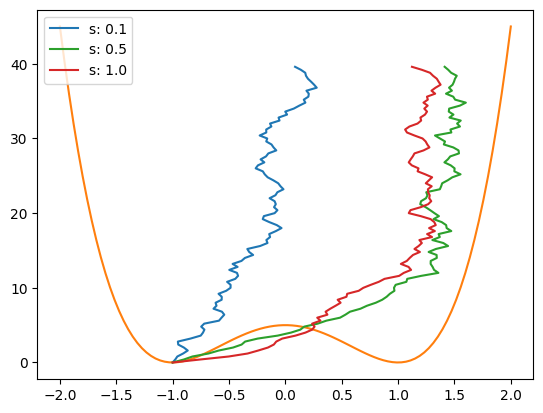

In [4]:
key = jax.random.key(0)
# b = uref # initialize b as uref
# schedule = [0.2,0.4,0.6,0.8,1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# schedule = [0.2, 0.4, 0.6, 0.8, 1.0]
schedule = [0.1, 0.5, 1.0]
# schedule = [0.1,] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]





def I_UREF_TPS(x, time, uref):
    x = x.reshape((-1, ndims))
    dt = time[1]-time[0]
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, uref)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - uref(xt, t)).dot(dxdt - uref(xt, t)) + 0.5*div_u)) (x, time, div_us, dxdts)
    return jnp.sum(out)        


b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)
A = 0
dbds = MLP([3,20,20,1], key=jax.random.key(0))
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    b, A = update_non_amortized(
        V=make_double_well_potential(v=5.0),
        b=b, # lambda x, t : jnp.array([0.0]),
        J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams={'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :200},
        key=key,
        schedule=schedule,
        i=i,
        # I=I_UREF_TPS,
        prior='sde_prior',
        A=A,
        refine=False
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)

old s 0.0
Train loss: 426483.65625
Test loss is 484870.375
old s 0.1
Train loss: 68838.859375
Test loss is 75415.859375
old s 0.5
Train loss: 4446.94873046875
Test loss is 3912.728271484375


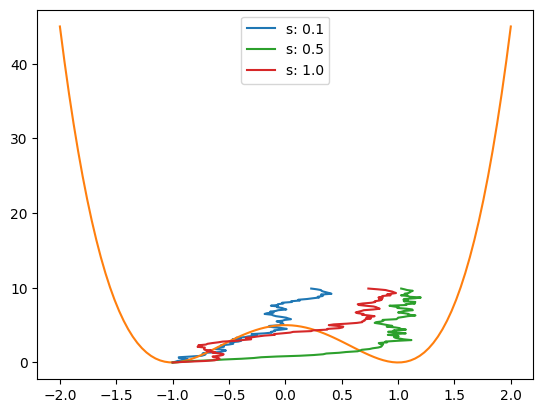

In [4]:
key = jax.random.key(0)
# b = uref # initialize b as uref
# schedule = [0.2,0.4,0.6,0.8,1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# schedule = [0.2, 0.4, 0.6, 0.8, 1.0]
schedule = [0.1,0.5,1.0]
# schedule = [0.1,] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]



from path_sampling import dfdt, div_f, update, update_non_amortized


def I_UREF_TPS(x, time, uref):
    x = x.reshape((-1, ndims))
    dt = time[1]-time[0]
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, uref)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - uref(xt, t)).dot(dxdt - uref(xt, t)) + 0.5*div_u)) (x, time, div_us, dxdts)
    return jnp.sum(out)        


b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)
A = 0
dbds = MLP([3,20,20,1], key=jax.random.key(0))
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    dbds, A = update(
        V=make_double_well_potential(v=5.0),
        uref=b, # lambda x, t : jnp.array([0.0]),
        J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams={'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :200},
        key=key,
        schedule=schedule,
        i=i,
        # I=I_UREF_TPS,
        prior='sde_prior',
        A=A,
        refine=False
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)

old s 0.0
Train loss: 67033.09375
Test loss is 271127.03125
OM of path 1431.4576
old s 0.2
Train loss: 46053.3671875
Test loss is 642205.8125
OM of path 75.4251
old s 0.4
Train loss: 208.8345184326172
Test loss is 2556.216064453125
OM of path 40.85113
old s 0.6
Train loss: 96.90729522705078
Test loss is 1712289.875
OM of path 83.31321
old s 0.8
Train loss: 94.94934844970703
Test loss is 5965.46923828125
OM of path 37.2854


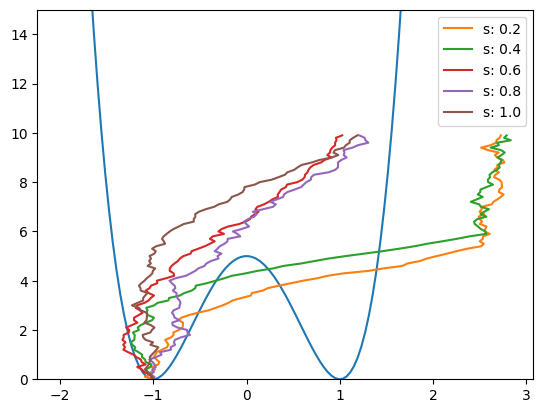

In [8]:
key = jax.random.key(0)
# b = uref # initialize b as uref
# schedule = [0.2,0.4,0.6,0.8,1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
schedule = [0.2, 0.4, 0.6, 0.8, 1.0]
# schedule = [0.1,] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]



from path_sampling import dfdt, div_f, update, update_non_amortized


def I_UREF_TPS(x, time, uref):
    x = x.reshape((-1, ndims))
    dt = time[1]-time[0]
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, uref)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - uref(xt, t)).dot(dxdt - uref(xt, t)) + 0.5*div_u)) (x, time, div_us, dxdts)
    return jnp.sum(out)        


b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)
A = 0
dbds = MLP([3,20,20,1], key=jax.random.key(0))
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    dbds, A = update(
        b=b, # lambda x, t : jnp.array([0.0]),
        J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams={'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 5000, 'batch_size' :200},
        key=key,
        schedule=schedule,
        i=i,
        I=I_UREF_TPS,
        A=A,
        refine=True
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)

In [10]:
A

Array(-120.54646, dtype=float32)

## SDE prior, brownian bridge posterior

old s 0.0
Train loss: 5346.3837890625
Test loss is 20322594.0
old s 0.1
Train loss: 2206.822998046875
Test loss is 1582534.0


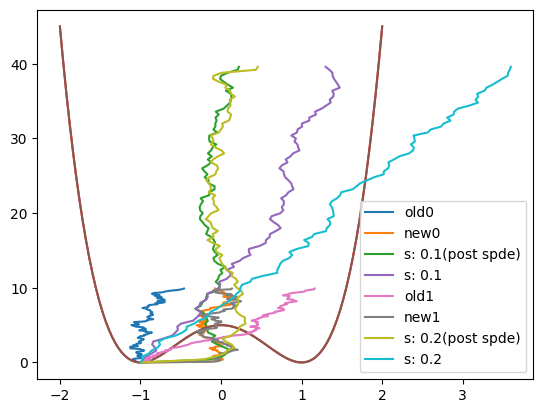

In [6]:
key = jax.random.key(0)
# b = uref # initialize b as uref
# schedule = [0.2,0.4,0.6,0.8,1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# schedule = [0.2, 0.4, 0.6, 0.8, 1.0]
schedule = [0.1, 0.2]
# schedule = [0.1]
# schedule = [0.01, 0.02]


hyperparams={'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' : 200}

# b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)
b = lambda x, t: 0.0
A = 0
dbds = MLP([3,20,20,1], key=jax.random.key(1))
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    b, A = update_non_amortized(
        # V=make_double_well_potential(v=5.0),
        V=lambda x: 0.0,
        b=b, # lambda x, t : jnp.array([0.0]),
        J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams=hyperparams,
        key=key,
        schedule=schedule,
        i=i,
        # I=I_UREF_TPS,
        prior='sde_prior',
        A=A,
        refine=True
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)

In [14]:
from path_sampling import make_b



# b = make_b(schedule[:i], uref, dbds)

# b = make_b(schedule[:i], uref, dbds)

path_key, model_key, refine_key = jax.random.split(key, 3)

W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))


# xs : [batch_size, num_steps, ndims]
xs, times = jax.pmap(lambda key:sample_sde(
b=b, 
W = W,
rho =  lambda key: jnp.zeros((ndims,))-1,
key=key, 
dt=hyperparams['dt'], 
num_steps=hyperparams['num_steps']))(jax.random.split(path_key, hyperparams['batch_size']))

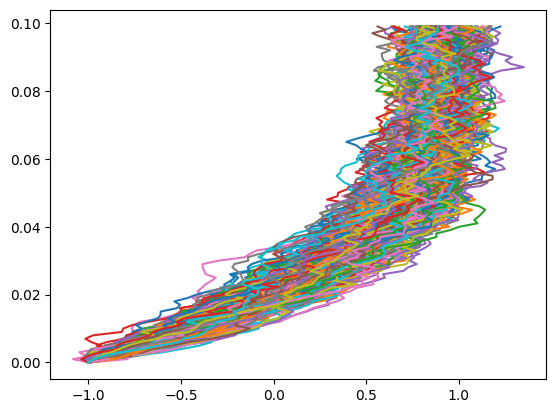

In [15]:
for path in xs:
    plt.plot(path, times[0])

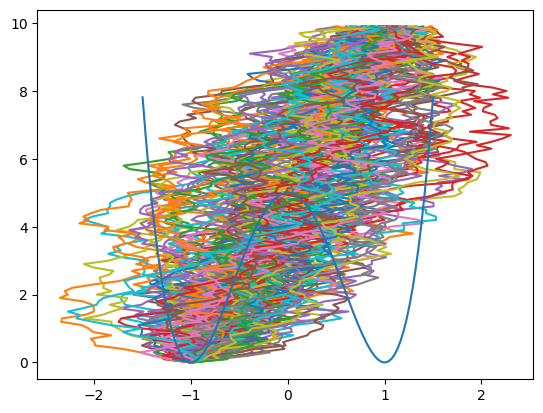

In [41]:
# estimate marginals
from path_sampling import make_double_well_potential, sample_sde


hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}


paths, times = jax.pmap(lambda k: sample_sde(
    b= lambda x,t: (1 - x)/(1-t), 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=k, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(key, 100))

# visualize path
for path, time in zip(paths, times):
    plt.plot(path,time*10)
# plot potential
x = np.linspace(-1.5, 1.5, 100)

plt.plot(x, potential(x[:, None]))

In [16]:
paths[:, 0].mean()

Array(-1., dtype=float32)

# Brownian bridge TPS

old s 0.0
Train loss: 1537603.875
Test loss is 24009014.0
old s 0.1
Train loss: 1320979.25
Test loss is 242637.296875
old s 0.5
Train loss: 32042.400390625
Test loss is 6997.4306640625


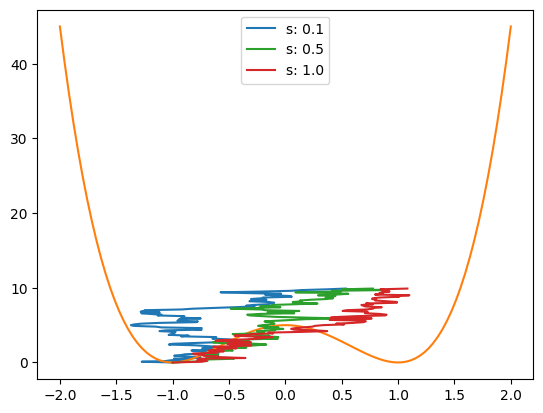

In [5]:
# key = jax.random.key(0)
# b = uref # initialize b as uref
# schedule = [0.1, 0.2] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# dbds = MLP([3,20,20,1], key=jax.random.key(0))

hyperparams = {'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :200}

brownian_bridge_drift = lambda x,t: (1 - x)/(1-t)

# potential = lambda x: jnp.sum(x**4 - 8 * x**2)
# force = jax.grad(lambda x: -jnp.sum(x**4 - 8 * x**2))

## TODO check if off by negation
# def I_brownian_bridge(x, time, b):
#     x = x.reshape((-1, ndims))
#     dt = hyperparams['dt']
#     print(dt)
#     dxdts = dfdt(x, dt)
#     out = jax.vmap(lambda xt,t, dxdt : 0.25*dt*((dxdt).dot(dxdt)) )(x, time, dxdts)
#     # div = jax.vmap(lambda xt,t, div_u, dxdt : div_u)(x, time, div_us, dxdts)
#     # jax.debug.print("div {x}", x=jnp.sum(div))
#     return jnp.sum(out)-((1/0.01)*jnp.linalg.norm(x[1,0] + 1)**2)-((1/0.01)*jnp.linalg.norm(x[-1,0] - 1)**2)

def make_J_brownian_bridge(dt, V):
    def J_brownian_bridge(x, y):

        # x = x[:, 0]

        # laplacian of the potential
        # pot = lambda x: 5.0*(x**2 - 1)**2
        nabla_V = jax.grad(V)
        laplacian_of_potential = jax.vmap(lambda k: jnp.trace(jax.jacfwd(nabla_V)(k)))(x)


        # jax.debug.print("force x0 {x}", x=force(x[0]))
        return 0.5*jnp.sum(jax.vmap(lambda xt, dv : dt*(0.5*nabla_V(xt).dot(nabla_V(xt)) - dv) )(x, laplacian_of_potential))
    return J_brownian_bridge


key = jax.random.key(0)
# b = uref # initialize b as uref
schedule = [0.1,0.5, 1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dbds = MLP([3,20,20,1], key=jax.random.key(0))

rho = lambda key: jnp.zeros((ndims,))-1.
W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))
 
V = make_double_well_potential(v=5.0)
b = brownian_bridge_drift
A = 0
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # xs, times = sample_sde(
    #     b=lambda x,t: (1 - x)/(1-t), 
    #     W = W,
    #     rho = rho,
    #     key=key, 
    #     dt=hyperparams['dt'], 
    #     num_steps=hyperparams['num_steps'])
    
    # plt.plot(xs[:,0],times)

    # raise Exception


    # update b -> b + dbds
    # b, A = update_non_amortized(
    #     V=V,
    #     b=b, # lambda x, t : jnp.array([0.0]),
    #     J=make_J_brownian_bridge(hyperparams['dt'], V),
    #     prior='brownian',
    #     dbds=dbds,
    #     hyperparams=hyperparams,
    #     key=key,
    #     schedule=schedule,
    #     i=i,
    #     A=A,
    #     refine=True
    # )
    
    dbds, A = update(
        V=V,
        uref=b, # lambda x, t : jnp.array([0.0]),
        J=make_J_brownian_bridge(hyperparams['dt'], V),
        prior='brownian',
        dbds=dbds,
        hyperparams=hyperparams,
        key=key,
        schedule=schedule,
        i=i,
        A=A,
        refine=True
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)

In [6]:
A

Array(-17.059683, dtype=float32)

old s 0.0
Train loss: 5727522.5
Test loss is 19244834.0
0.01
OM of path 48.126045
old s 0.1
Train loss: 4550.68017578125
Test loss is 4347.533203125
0.01
OM of path 63.795948
old s 0.5
Train loss: 50433.296875
Test loss is 58128.921875
0.01
OM of path 41.33809


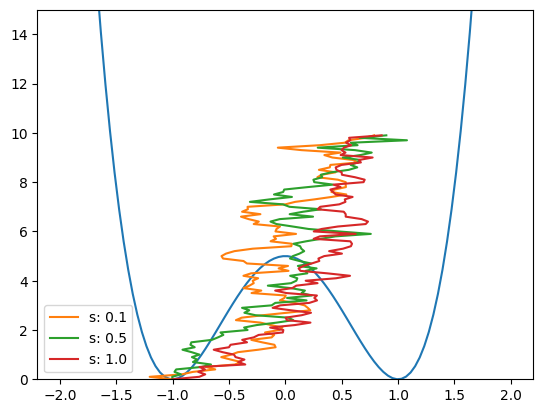

In [16]:
# key = jax.random.key(0)
# b = uref # initialize b as uref
# schedule = [0.1, 0.2] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# dbds = MLP([3,20,20,1], key=jax.random.key(0))

hyperparams = {'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :200}

brownian_bridge_drift = lambda x,t: (1 - x)/(1-t)

# potential = lambda x: jnp.sum(x**4 - 8 * x**2)
# force = jax.grad(lambda x: -jnp.sum(x**4 - 8 * x**2))

## TODO check if off by negation
def I_brownian_bridge(x, time, b):
    x = x.reshape((-1, ndims))
    dt = hyperparams['dt']
    print(dt)
    dxdts = dfdt(x, dt)
    out = jax.vmap(lambda xt,t, dxdt : 0.25*dt*((dxdt).dot(dxdt)) )(x, time, dxdts)
    # div = jax.vmap(lambda xt,t, div_u, dxdt : div_u)(x, time, div_us, dxdts)
    # jax.debug.print("div {x}", x=jnp.sum(div))
    return jnp.sum(out)-((1/0.01)*jnp.linalg.norm(x[1,0] + 1)**2)-((1/0.01)*jnp.linalg.norm(x[-1,0] - 1)**2)

def make_brownian_bridge_potential(dt):
    def J_brownian_bridge(x, y):

        x = x[:, 0]

        # laplacian of the potential
        pot = lambda x: 5.0*(x**2 - 1)**2
        # pot = make_double_well_potential(v=5.0)
        nabla_V = jax.grad(pot)
        laplacian_of_potential = jax.vmap(jax.grad(nabla_V))(x)


        # jax.debug.print("force x0 {x}", x=force(x[0]))
        return 0.5*jnp.sum(jax.vmap(lambda xt, dv : dt*(0.5*nabla_V(xt).dot(nabla_V(xt)) - dv) )(x, laplacian_of_potential))
    return J_brownian_bridge


key = jax.random.key(0)
# b = uref # initialize b as uref
schedule = [0.1,0.5, 1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dbds = MLP([3,20,20,1], key=jax.random.key(0))

rho = lambda key: jnp.zeros((ndims,))-1.
W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))
 

b = brownian_bridge_drift
A = 0
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # xs, times = sample_sde(
    #     b=lambda x,t: (1 - x)/(1-t), 
    #     W = W,
    #     rho = rho,
    #     key=key, 
    #     dt=hyperparams['dt'], 
    #     num_steps=hyperparams['num_steps'])
    
    # plt.plot(xs[:,0],times)

    # raise Exception

    # update b -> b + dbds
    dbds, A = update(
        uref=b, # lambda x, t : jnp.array([0.0]),
        J=make_brownian_bridge_potential(hyperparams['dt']),
        I=I_brownian_bridge,
        dbds=dbds,
        hyperparams=hyperparams,
        key=key,
        schedule=schedule,
        i=i,
        A=A,
        refine=False
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)

In [110]:
# def new_b(x, t): 
#     # assert x.shape[0] == ndims
#     return -jax.grad(lambda x: (x**4 - 8 * x**2))(x)

hyperparams={'dt': 0.001, 'num_steps': 200, 'num_training_steps' : 1000}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']


path_key = jax.random.key(1)
xs, times = jax.pmap(lambda key:sample_sde(
    b=uref, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 1))


def I_exp(x, time, b):
    x = x.reshape((-1, ndims))
    dt = hyperparams['dt']
    print(dt)
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, b)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - b(xt, t)).dot(dxdt - b(xt, t)) + 0.5*div_u) )(x, time, div_us, dxdts)
    # div = jax.vmap(lambda xt,t, div_u, dxdt : div_u)(x, time, div_us, dxdts)
    # jax.debug.print("div {x}", x=jnp.sum(div))
    return jnp.sum(out)


# use mcmc with the onsager machlup functional to correct samples

def refine_path_exp(x, s, time, rng_key, num_steps):
    initial_position = x.reshape(x.shape[0]*x.shape[1])

    # logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=0.01)-I_exp(x, time, lambda k, t: uref(k,t)) 
    logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=0.01)-I_exp(x, time, uref) - s*J(x.reshape((-1, ndims)), None)

    # logdensity_fn = lambda x: I(x, time, uref) 

    samples, _, params, chain_key = run_mclmc(
        logdensity_fn=logdensity_fn,
        num_steps=num_steps,
        initial_position=initial_position,
        key=rng_key,
        transform=lambda state, info: state.position
    )

    return samples[-1]




samples = refine_path_exp(
    x=xs[0],
    s=0.0,
    time=time,
    rng_key=jax.random.key(0),
    num_steps=100000
)



0.001
0.001
0.001
0.001
0.001
0.001
0.001


(200,)


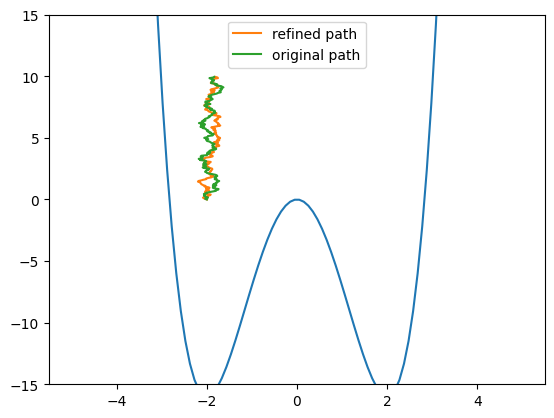

In [111]:
# plot samples[-1]
print(samples.shape)
# plt.plot(samples[0, :])
# hyperparams['dt']

# (time/hyperparams['dt']) / 5
# time

x = jnp.expand_dims(jnp.linspace(-5, 5, 100), 1)
y = (x**4 - 8 * x**2)
plt.ylim(-15,15)
plt.plot(x, y)
plt.plot(samples[:],(time/hyperparams['dt'])/20, label='refined path')
plt.plot(xs[0],(time/hyperparams['dt'])/20, label='original path')
plt.legend()

In [40]:
I_exp(samples, time, uref)
# samples.shape

0.001


Array(116.70465, dtype=float32)

## Brownian sanity check

In [50]:
# # def new_b(x, t): 
# #     # assert x.shape[0] == ndims
# #     return -jax.grad(lambda x: (x**4 - 8 * x**2))(x)

# hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}

# time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']


# path_key = jax.random.key(0)
# xs_true, times = jax.pmap(lambda key:sample_sde(
#     b=lambda x,t: (1- x)/(1-t),
#     W = lambda _, key: jax.random.normal(key, shape=(ndims,)),
#     # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
#     rho = lambda key: jnp.zeros((ndims,))-1.,
#     key=key, 
#     dt=hyperparams['dt'], 
#     num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 100))

# xs, times = jax.pmap(lambda key:sample_sde(
#     b=lambda x,t: 0.0,
#     W = lambda _, key: jax.random.normal(key, shape=(ndims,)),
#     # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
#     rho = lambda key: jnp.zeros((ndims,))-1.,
#     key=key, 
#     dt=hyperparams['dt'], 
#     num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 1))


# def J_exp(x,y):
#     """
#     x: path of the SDE, array of shape [num_steps, ndims]
#     y: observation, here ignored, so assume it's `None`

#     Returns:
#         a scalar value representing the cost of the path
#     """

#     sigma = 0.1
#     return (1/sigma**2)*(x[-1,0]- 1)**2

# def I_exp(x, time, b):
#     x = x.reshape((-1, ndims))
#     dt = hyperparams['dt']
#     print(dt)
#     dxdts = dfdt(x, dt)
#     div_us = div_f(x, time, b)
#     out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - b(xt, t)).dot(dxdt - b(xt, t)) + 0.5*div_u) )(x, time, div_us, dxdts)
#     # div = jax.vmap(lambda xt,t, div_u, dxdt : div_u)(x, time, div_us, dxdts)
#     # jax.debug.print("div {x}", x=jnp.sum(div))
#     return jnp.sum(out)


# # use mcmc with the onsager machlup functional to correct samples

# def refine_path_exp(x, s, time, rng_key, num_steps):
#     initial_position = x.reshape(x.shape[0]*x.shape[1])

#     # logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=0.01)-I_exp(x, time, lambda k, t: uref(k,t)) 
#     logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-1, scale=0.01)-I_exp(x, time, uref) - s*J_exp(x.reshape((-1, ndims)), None)

#     # logdensity_fn = lambda x: I(x, time, uref) 

#     samples, _, params, chain_key = run_mclmc(
#         logdensity_fn=logdensity_fn,
#         num_steps=num_steps,
#         initial_position=initial_position,
#         key=rng_key,
#         transform=lambda state, info: state.position
#     )

#     return samples[-1]




# samples = refine_path_exp(
#     x=xs[0],
#     s=1.0,
#     time=time,
#     rng_key=jax.random.key(0),
#     num_steps=10000
# )

0.01
0.01
0.01
0.01
0.01
0.01
0.01


# Brownian bridge TPS

In [89]:
# def new_b(x, t): 
#     # assert x.shape[0] == ndims
#     return -jax.grad(lambda x: (x**4 - 8 * x**2))(x)

hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']


path_key = jax.random.key(0)
# xs_true, times = jax.pmap(lambda key:sample_sde(
#     b=lambda x,t: (1- x)/(1-t),
#     W = lambda _, key: jax.random.normal(key, shape=(ndims,)),
#     # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
#     rho = lambda key: jnp.zeros((ndims,))-1.,
#     key=key, 
#     dt=hyperparams['dt'], 
#     num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 100))

xs, times = jax.pmap(lambda key:sample_sde(
    b=lambda x,t: 0.0,
    W = lambda _, key: jax.random.normal(key, shape=(ndims,)),
    # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 1))


# nabla_V = lambda y: jax.grad(lambda x: potential(x))(y)[0]

def J_exp(x,y):

    x = x[:, 0]
    # print("x", x.shape)

    eps = 1. # hyperparams['dt']
    # laplacian of the potential
    pot = lambda x: (x**2 - 1)**2
    nabla_V = jax.grad(pot)
    laplacian_of_potential = jax.vmap(jax.grad(nabla_V))(x)


    # jax.debug.print("force x0 {x}", x=force(x[0]))
    return (1/(2*eps**2))*jnp.sum(jax.vmap(lambda xt, dv :  0.5*eps*(nabla_V(xt).dot(nabla_V(xt)) - eps*dv) )(x, laplacian_of_potential))
                                                                                #   ))(x, dVs))

def I_exp(x, time, b):
    x = x.reshape((-1, ndims))
    dt = hyperparams['dt']
    print(dt)
    dxdts = dfdt(x, dt)
    out = jax.vmap(lambda xt,t, dxdt : 0.25*dt*((dxdt).dot(dxdt)) )(x, time, dxdts)
    # div = jax.vmap(lambda xt,t, div_u, dxdt : div_u)(x, time, div_us, dxdts)
    # jax.debug.print("div {x}", x=jnp.sum(div))
    return jnp.sum(out)+((1/0.01)*jnp.linalg.norm(x[1,0] + 1)**2)+((1/0.01)*jnp.linalg.norm(x[-1,0] - 1)**2)


# use mcmc with the onsager machlup functional to correct samples

def refine_path_exp(x, s, time, rng_key, num_steps):
    initial_position = x.reshape(x.shape[0]*x.shape[1])

    # logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=0.01)-I_exp(x, time, lambda k, t: uref(k,t)) 
    logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-1, scale=0.01)-I_exp(x, time, uref) - s*J_exp(x.reshape((-1, ndims)), None)

    # logdensity_fn = lambda x: I(x, time, uref) 

    samples, _, params, chain_key = run_mclmc(
        logdensity_fn=logdensity_fn,
        num_steps=num_steps,
        initial_position=initial_position,
        key=rng_key,
        transform=lambda state, info: state.position
    )

    return samples[-1]




samples = refine_path_exp(
    x=xs[0],
    s=1.0,
    time=time,
    rng_key=jax.random.key(0),
    num_steps=10000
)

0.01
0.01
0.01
0.01
0.01
0.01
0.01


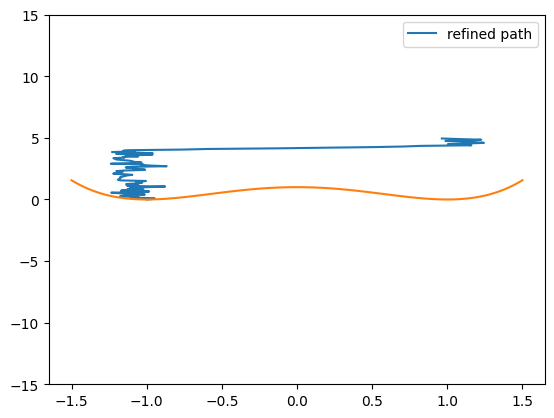

In [91]:
import matplotlib.pyplot as plt
plt.ylim(-15,15)
# plt.plot(xs[0,:,0],(time/hyperparams['dt'])/20, label='original path')
plt.plot(samples,(time/hyperparams['dt'])/20, label='refined path')
x = np.linspace(-1.5, 1.5, 100)

plt.plot(x, make_double_well_potential(v=1.0)(x[:, None]))
plt.legend()

# xs

## SPDE approach

In [228]:
hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']


force = jax.grad(lambda x: -jnp.sum(x**4 - 8 * x**2))


def numerical_laplacian(arr, dt):

    arr = jnp.concatenate([jnp.array([arr[0]]), arr, jnp.array([arr[-1]])])
    fst_diff = (arr[1:] - arr[:-1])
    snd_diff = (fst_diff[1:] - fst_diff[:-1])
    jax.debug.print("snd_diff {x}", x=snd_diff)
    return snd_diff

def spde_integrator(x, force, sigma=1, num_steps=10):
    ds = 0.01


    def step(x):

        # second_difference = (first_difference[:-1] - ) / hyperparams['dt']
        laplace_t_x = numerical_laplacian(x, dt=hyperparams['dt'])
        term2 = -jax.vmap(force)(x)*jax.vmap(jax.grad(force))(x)
        term3 = -(sigma**2)*jax.vmap(jax.grad(jax.grad(force)))(x)
        noise = jnp.sqrt(2)*jax.random.normal(key, shape=x.shape)

        return x + ds*(1/(sigma**2))*(laplace_t_x + term2 + term3) + jnp.sqrt(ds)*noise
    
    for i in range(num_steps):
        x = step(x)
        # print(x.shape)

    return x

# spde_integrator(
#     x=jnp.array([1.,2.,1.,4.,5.,1.,1.]),
#     force=force,
#     ).shape



initial = jnp.linspace(-1,1, 100)
# initial


snd_diff [ 2.0202041e-02  0.0000000e+00 -1.1920929e-07  1.1920929e-07
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -1.1920929e-07  1.1920929e-07  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -1.1920929e-07  1.1920929e-07
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.1920929e-07
  2.3841858e-07 -2.3841858e-07  1.1920929e-07  0.0000000e+00
 -8.9406967e-08  1.4901161e-07 -1.1920929e-07  2.9802322e-08
  2.9802322e-08  0.0000000e+00 -2.9802322e-08 -2.9802322e-08
  1.1920929e-07 -1.4901161e-07  8.9406967e-08  0.0000000e+00
 -8.9406967e-08  1.4901161e-07 -1.1920929e-07  2.9802322e-08
  2.9802322e-08  0.0000000e+00 -2.9802322e-08 -2.9802322e-08
  1.1920929e-07 -1.4901161e-07  8.9406967e-08  0.0000000e+00
 -8.9406967e-08  5.9604645e-08  2.9802322e-08  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.1920929e-07
  1.1920929e-07  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -1.1920929e-07  1.1920929e-07  0.0000000e+00
  0.0000000e+00

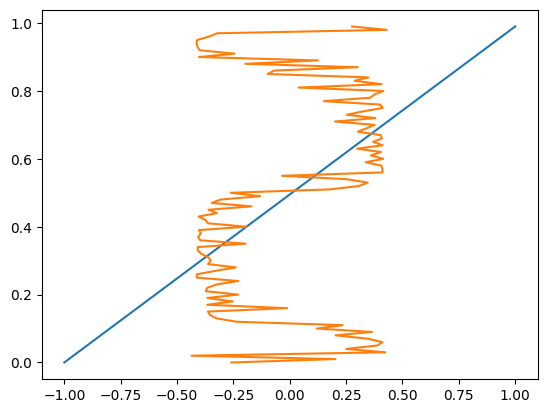

In [229]:
# plot initial
time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']
plt.plot(initial, time, label='initial')
x = spde_integrator(
    x=jnp.array(initial),
    force=force,
    )
# initial.shape
plt.plot(x, time, label='integrated')

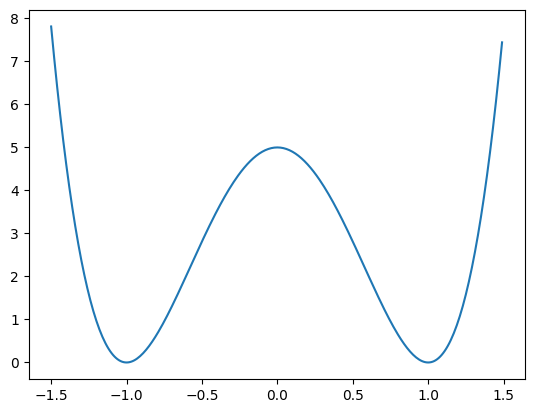

In [242]:
# plot (x^2 - 1)^2
inp = jnp.arange(start=-1.5, stop=1.5, step=0.01)
# inp
plt.plot(inp, 5*(inp**2 - 1)**2, label='potential')